In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import math
import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# **Preprocessing: Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

In [3]:
train_pixel_file = pd.read_csv('/content/drive/MyDrive/prac2/data/test_set_pixel_size.csv')
train_pixel_file.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [ ]:
# Take annotation and spit out corresponding mask
mask_save_dir = '/content/drive/MyDrive/prac2/data/mask'

def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

In [ ]:
# Check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('/content/drive/MyDrive/prac2/data/training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [ ]:
for index in range(len(train_pixel_file)):
    file_path = os.path.join('/content/drive/MyDrive/prac2/data/training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    save_path = os.path.join(mask_save_dir, os.path.basename(file_path))
    cv2.imwrite(save_path, mask)

**Warning!!!**
**Done with mask generation. Don't run above cells ever again**

# Dataset classes

In [18]:
class HC18(Dataset):
    def __init__(self, root_dir, train=True, transformX=None, transformY=None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size=0.2, random_state=5)

    def __len__(self):
      if self.train:
        length = len(self.train_data)
      else:
        length = len(self.validation_data)
      return length

    def __getitem__(self, index):
      data = self.train_data if self.train else self.validation_data
      imx_name = os.path.join(self.root_dir, 'training_set', data.iloc[index, 0])
      imy_name = os.path.join(self.root_dir, 'training_set', data.iloc[index, 0].replace('.png','_Annotation.png'))
      # imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
      # imy_name = os.path.join(self.root_dir, 'training_set',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))
      # imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
      # imy_name = os.path.join(self.root_dir, 'training_set',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))

      imx = Image.open(imx_name)
      imy = Image.open(imy_name).convert('L')

      # data augmentation
      if self.train:
        # horizontal flipping
        if random.random() > 0.5:
          imx = TF.hflip(imx)
          imy = TF.hflip(imy)
        # vertical flipping
        if random.random() > 0.5:
          imx = TF.vflip(imx)
          imy = TF.vflip(imy)
        # rotation
        if random.random() > 0.8:
          angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          imx = TF.rotate(imx, angle)
          imy = TF.rotate(imy, angle)

      if self.transformX:
        imx = self.transformX(imx)
        imy = self.transformY(imy)

        # sample = {'image': imx, 'annotation': imy}
        # return sample
        hc_value = data.iloc[index, 1]
        pixel_size = float(data.iloc[index, 2])
        return {'image': imx, 'annotation': imy, 'hc': torch.tensor(hc_value, dtype=torch.float32), 'pixel_size': pixel_size}

# Transformations

In [6]:
tx_X = transforms.Compose([transforms.Resize((572, 572)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                           ])
tx_Y = transforms.Compose([transforms.Resize((572, 572)),
                           transforms.ToTensor(),])

train_data = HC18('/content/drive/MyDrive/prac2/data', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('/content/drive/MyDrive/prac2/data', train = False, transformX = tx_X, transformY = tx_Y )
#test_data = HC18_test('/content/drive/MyDrive/prac2/data', transformX = tx_X)

train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)
#test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


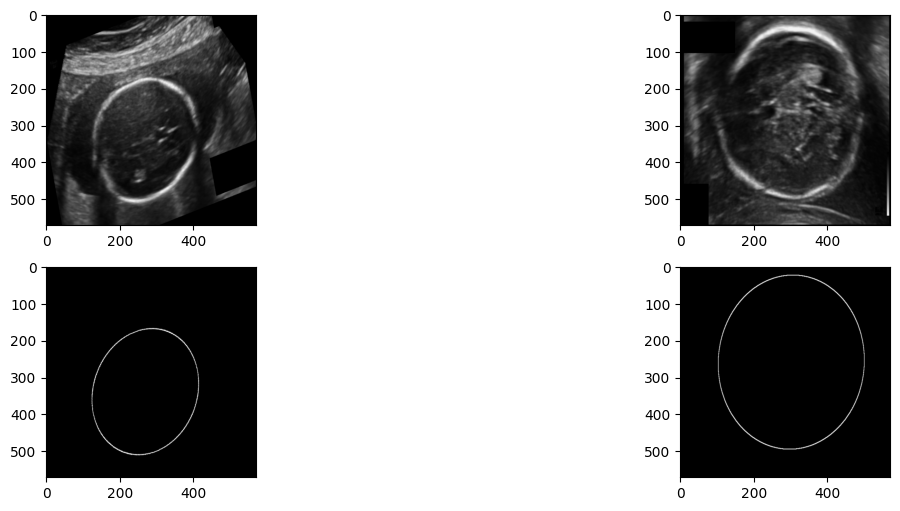

In [7]:
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)

    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

# Here we loop through our train_loader and see the images
fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())

    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

# U-Net model

In [8]:
class double_conv(nn.Module):
  '''(conv => BN => ReLU) * 2'''
  def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))
  def forward(self, x):
    x = self.conv(x)
    return x

class inconv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(inconv, self).__init__()
    self.conv = double_conv(in_ch, out_ch)
  def forward(self, x):
    x = self.conv(x)
    return x

class down(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(down, self).__init__()
    self.mpconv = nn.Sequential(
        nn.MaxPool2d(2),
        double_conv(in_ch, out_ch))
  def forward(self, x):
    x = self.mpconv(x)
    return x

class up(nn.Module):
  def __init__(self, in_ch, out_ch, bilinear=True):
    super(up, self).__init__()
    if bilinear: #upsampling will not be learnable
      self.up = nn.Upsample(
          scale_factor=2, mode='bilinear', align_corners=True)
    else:  # it will be learnable here
      self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
    self.conv = double_conv(in_ch, out_ch)
  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2))
    x = torch.cat([x2, x1], dim=1)
    x = self.conv(x)
    return x

class outconv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(outconv, self).__init__()
    self.conv = nn.Conv2d(in_ch, out_ch, 1)
  def forward(self, x):
    x = self.conv(x)
    return x

In [9]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    super(UNet, self).__init__()
    self.inc = inconv(n_channels, 64)
    self.down1 = down(64, 128)
    self.down2 = down(128, 256)
    self.down3 = down(256, 512)
    self.down4 = down(512, 512)
    self.up1 = up(1024, 256, bilinear = False) # upsampling weights are made learnable
    self.up2 = up(512, 128, bilinear = False)
    self.up3 = up(256, 64, bilinear = False)
    self.up4 = up(128, 64, bilinear = False)
    self.outc = outconv(64, n_classes)
    self.dropout = torch.nn.Dropout2d(0.5)

  def forward(self, x):
    x = x.float()
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.dropout(x)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    x = self.outc(x)
    return torch.sigmoid(x)

model = UNet(1, 1).to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


# Loss function

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0004)

# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
  smooth = 0.000001
  size_of_batch = y_pred.size(0)

  p1 = y_pred.view(size_of_batch, -1)
  p2 = y_actual.view(size_of_batch, -1)

  intersection = (p1 * p2).sum()
  dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)

  return dice

def dice_loss(y_predict, y_train):
  dice_loss = 1 - (dice_index(y_predict, y_train))
  return dice_loss

# Ellipse Fitting + Head Circumference Estimation

In [11]:
def extract_ellipse_params(mask_tensor):
    mask_np = mask_tensor.squeeze().cpu().numpy().astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_np, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0 or len(contours[0]) < 5:
        return None
    ellipse = cv2.fitEllipse(contours[0])
    center, axes, angle = ellipse
    major_axis, minor_axis = max(axes), min(axes)
    return major_axis, minor_axis, angle

def ellipse_circumference(a, b):
    h = ((a - b) ** 2) / ((a + b) ** 2)
    return math.pi * (a + b) * (1 + (3*h) / (10 + math.sqrt(4 - 3*h)))

# Training

In [12]:
epochs = 20

train_running_loss_history = []
validation_running_loss_history = []
train_mae_history = []
validation_mae_history = []

for e in range(epochs):
    model.train()
    train_running_loss = 0.0

    for sample_batched in train_loader:
        X_train = sample_batched['image'].to('cuda')
        y_train = sample_batched['annotation'].to('cuda')

        optimizer.zero_grad()
        y_pred = model(X_train)

        loss = 0.3 * dice_loss(y_pred, y_train) + 0.7 * criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

    # ======= After training loop: Compute train MAE =======
    model.eval()
    total_train_mae = 0.0
    train_count = 0
    with torch.no_grad():
        for sample_batched in train_loader:
            X_train = sample_batched['image'].to('cuda')
            y_pred = model(X_train)
            for i in range(X_train.size(0)):
                ellipse = extract_ellipse_params((y_pred[i] > 0.5).float())
                if ellipse:
                    a, b, _ = ellipse
                    pred_hc = ellipse_circumference(a, b)
                    true_hc = sample_batched['hc'][i].item()
                    total_train_mae += abs(pred_hc - true_hc)
                    train_count += 1

    avg_train_mae = total_train_mae / train_count if train_count > 0 else 0

    # ======= Validation loss and MAE =======
    validation_running_loss = 0.0
    total_val_mae = 0.0
    val_count = 0

    with torch.no_grad():
        for sample_batched in validation_loader:
            X_val = sample_batched['image'].to('cuda')
            y_val = sample_batched['annotation'].to('cuda')
            y_out = model(X_val)
            val_loss = 0.3 * dice_loss((y_out > 0.5).float(), y_val) + 0.7 * criterion(y_out, y_val)
            validation_running_loss += val_loss.item()

            for i in range(X_val.size(0)):
                ellipse = extract_ellipse_params((y_out[i] > 0.5).float())
                if ellipse:
                    a, b, _ = ellipse
                    pred_hc = ellipse_circumference(a, b)
                    true_hc = sample_batched['hc'][i].item()
                    total_val_mae += abs(pred_hc - true_hc)
                    val_count += 1

    train_loss = train_running_loss / len(train_loader)
    val_loss = validation_running_loss / len(validation_loader)
    val_mae = total_val_mae / val_count if val_count else 0

    # Save history
    train_running_loss_history.append(train_loss)
    validation_running_loss_history.append(val_loss)
    train_mae_history.append(avg_train_mae)
    validation_mae_history.append(val_mae)

    print(f"Epoch {e+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Train MAE:  {avg_train_mae:.3f} (pixels)")
    print(f"  Val MAE:    {val_mae:.3f} (pixels)")
    print("===================================")

    torch.cuda.empty_cache()

Epoch 1/20
  Train Loss: 0.3946
  Val Loss:   0.3420
  Train MAE:  0.000 (pixels)
  Val MAE:    0.000 (pixels)
Epoch 2/20
  Train Loss: 0.3123
  Val Loss:   0.2924
  Train MAE:  nan (pixels)
  Val MAE:    2101.069 (pixels)
Epoch 3/20
  Train Loss: 0.2878
  Val Loss:   0.2723
  Train MAE:  2100.384 (pixels)
  Val MAE:    1414346.199 (pixels)
Epoch 4/20
  Train Loss: 0.2791
  Val Loss:   0.2642
  Train MAE:  nan (pixels)
  Val MAE:    1764.909 (pixels)
Epoch 5/20
  Train Loss: 0.2745
  Val Loss:   0.2602
  Train MAE:  nan (pixels)
  Val MAE:    9246.768 (pixels)
Epoch 6/20
  Train Loss: 0.2730
  Val Loss:   0.2623
  Train MAE:  1686.209 (pixels)
  Val MAE:    2943.301 (pixels)
Epoch 7/20
  Train Loss: 0.2711
  Val Loss:   0.2618
  Train MAE:  nan (pixels)
  Val MAE:    1939.716 (pixels)
Epoch 8/20
  Train Loss: 0.2702
  Val Loss:   0.2604
  Train MAE:  1768.506 (pixels)
  Val MAE:    11269.586 (pixels)
Epoch 9/20
  Train Loss: 0.2681
  Val Loss:   0.2571
  Train MAE:  408472.040 (pixels)

# Ellipse HC Estimation from Mask

In [13]:
def extract_ellipse_params(mask_tensor):
    mask_np = mask_tensor.squeeze().cpu().numpy().astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_np, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0 or len(contours[0]) < 5:
        return None
    ellipse = cv2.fitEllipse(contours[0])
    center, axes, angle = ellipse
    major_axis, minor_axis = max(axes), min(axes)
    return major_axis, minor_axis, angle

def ellipse_circumference(a, b):
    h = ((a - b)**2) / ((a + b)**2)
    return math.pi * (a + b) * (1 + (3*h)/(10 + math.sqrt(4 - 3*h)))

# Visualization

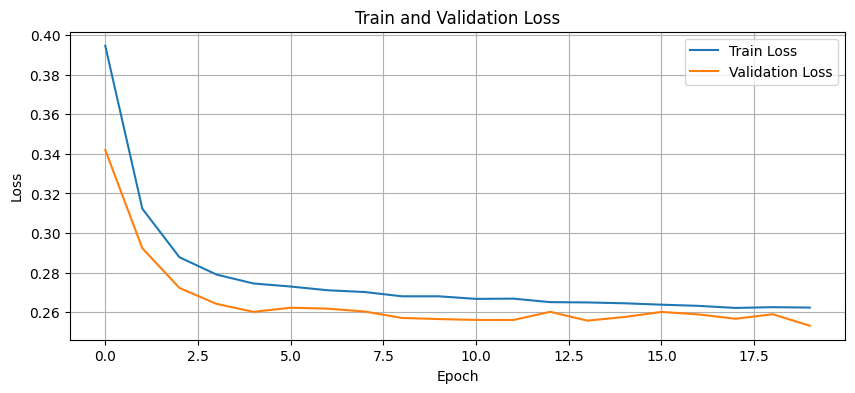

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(train_running_loss_history, label='Train Loss')
plt.plot(validation_running_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()